# Start

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import glob
import pathlib
import random
import tqdm.notebook as tqdm
import matplotlib

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import scipy
import sklearn.datasets
import textblob
import torch
import yaml

import map_estimate
import run_ip
import text_vae
import train
import utils

In [3]:
def queries_to_epsilon(save_data, epsilon_thresholds, stopping_criterion='mutual_information'):
    epsilon_thresholds = torch.tensor(epsilon_thresholds)

    num_queries = []
    for i, data in save_data.items():
        if 'mutual_information' in data:
            if stopping_criterion == 'mutual_information':
                eps = torch.tensor([mi.max() for mi in data['mutual_information']] + [0])
            else:
                eps = 1 - data['log_posteriors'].exp().amax(dim=1)
            comp_matrix = torch.ones((len(epsilon_thresholds), len(eps)))
            comp_matrix[eps.unsqueeze(0) > epsilon_thresholds.unsqueeze(1)] = float("inf")
            num_queries.append(comp_matrix.argmin(dim=1))
    
    return torch.stack(num_queries)

def accuracy_at_epsilon(save_data, eps_thresholds, first_k=None, dataset=None, stopping_criterion='mutual_information'):
    # first_k argument is useful when we want to compare the predictions of two IP runs
    # on the first_k problems in the dataset
    if first_k is None:
        first_k = len(save_data)
    
    if dataset is None:
        dataset = ds

    num_correct = torch.zeros(len(eps_thresholds))
    num_total = 0
    queries_to_thresholds = queries_to_epsilon(save_data, eps_thresholds)
    
    for data_idx, data in itertools.islice(save_data.items(), first_k):
        if 'log_posteriors' in data:
            x, y = dataset[data_idx][:2]
            preds = data['log_posteriors'][queries_to_thresholds[num_total].clamp(max=len(data['log_posteriors'])-1)].argmax(dim=1)
            num_correct += preds == y
            num_total += 1

    return num_correct / num_total

# NLP Exploratory Data Analysis

In [39]:
df_huffpost = pd.read_json("data/doc_classification/News_Category_Dataset_v2.json", lines=True)
df_huffpost["Text"] = df_huffpost["headline"] + " " + df_huffpost["short_description"]

In [259]:
categories_to_remove = ['IMPACT', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'GREEN', 'THE WORLDPOST', 'WORLDPOST', 'FIFTY']
df_huffpost_clean = df_huffpost[~df_huffpost['category'].isin(categories_to_remove)].reset_index()

def rename(x):
    if x == 'PARENTS':
        return'PARENTING'
    if x in ['ARTS', 'CULTURE & ARTS']:
        return 'ARTS & CULTURE'
    if x == 'STYLE':
        return 'STYLE & BEAUTY'
    if x == 'TASTE':
        return 'FOOD & DRINK'
    if x == 'HEALTHY LIVING':
        return 'HOME & LIVING'
    return x
df_huffpost_clean['category'] = df_huffpost_clean['category'].map(rename)

df_huffpost_clean.to_json('data/doc_classification/News_Category_Dataset_Cleaned_Categories.json', orient='records', lines=True)
# df_huffpost = df_huffpost_clean

In [269]:
top10_categories = (
   df_huffpost_clean["category"].value_counts(ascending=True).index.tolist()[-10:]
)
df_huffpost_clean10 = df_huffpost_clean[df_huffpost_clean["category"].isin(top10_categories)].reset_index()
df_huffpost_clean10.to_json('data/doc_classification/News_Category_Dataset_Cleaned_Categories10.json', orient='records', lines=True)
df_huffpost = df_huffpost_clean10

In [270]:
print(f"Dataset size: {len(df_huffpost)}")
print(f"Unique labels: {len(df_huffpost['category'].unique())}")

Dataset size: 132508
Unique labels: 10


In [271]:
for i in np.random.choice(len(df_huffpost), 10):
    print(i, df_huffpost["category"][i], "-", df_huffpost["Text"][i])

103854 WELLNESS - Greek Yogurt Food Invasion Continues As Product Is Added To Cream Cheese, Hummus And More It's been a whirlwind past few years for the Greek yogurt industry. Greek yogurt has gone from one percent of the yogurt
34291 POLITICS - Rick Perry On Donald Trump's Proposed Border Wall: 'You Can't Do That' The former Texas governor says  "a technological wall" is more likely.
127256 STYLE & BEAUTY - Petra Nemcova, Jamie Belman Split: Model & Actor End Their Engagement (PHOTOS) A spokesman for Next Models confirmed to Vogue UK that the couple had split. We're so sad about this split! Check out some
31399 POLITICS - Fed Up Congressman Brings Mosquitoes To Congress Florida Republican David Jolly displayed a jar of the bloodsuckers on the House floor to prompt action on Zika. Paul Ryan yawned.
43619 POLITICS - Obamas Invite Businessman Who Helps Low-Income Residents Afford Solar Panels To State Of The Union When Mark Davis' clients install solar panels, their energy costs drop by 

Labels: ['ENTERTAINMENT' 'POLITICS' 'QUEER VOICES' 'BUSINESS' 'TRAVEL' 'PARENTING'
 'STYLE & BEAUTY' 'FOOD & DRINK' 'HOME & LIVING' 'WELLNESS']


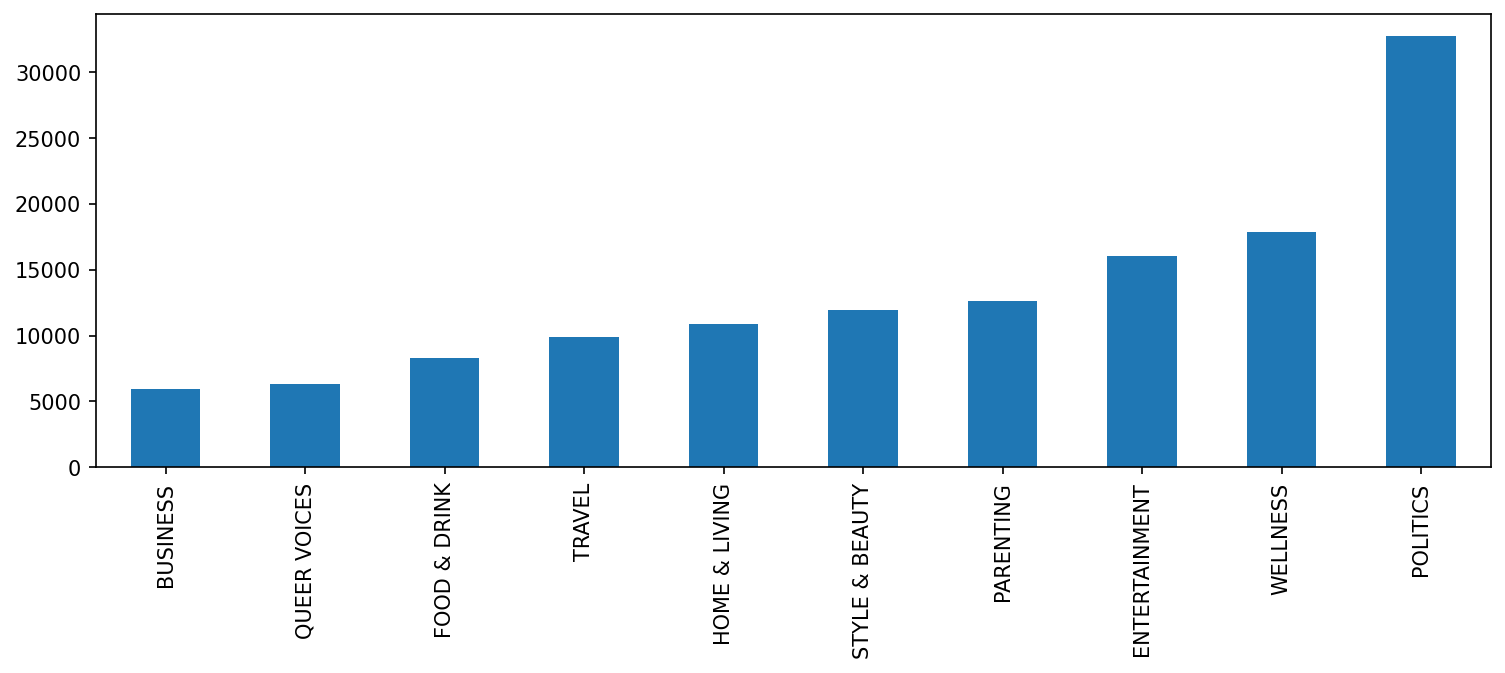

In [272]:
print(f"Labels: {df_huffpost['category'].unique()}")

plt.figure(figsize=(12, 4), dpi=150)
df_huffpost["category"].value_counts(ascending=True).plot(kind="bar")
plt.xticks(rotation='vertical')
plt.show()

In [274]:
blob = textblob.TextBlob(df_huffpost["Text"].str.cat(sep=" ").lower())
words = [token.stem() for token in blob.words]

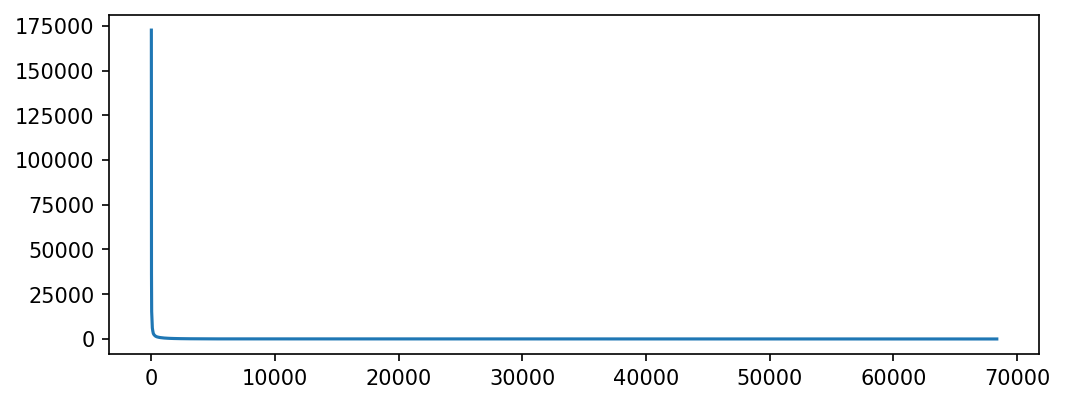

In [275]:
w, counts = np.unique(words, return_counts=True)

plt.figure(figsize=(8, 3), dpi=150)
plt.plot(np.sort(counts)[::-1])
plt.show()

In [276]:
list(w[np.argsort(counts)[::-1]][:20])

['the',
 'to',
 'a',
 'of',
 'and',
 'in',
 "'s",
 'is',
 'for',
 'it',
 'you',
 'that',
 'i',
 'on',
 'with',
 'are',
 'be',
 'we',
 'your',
 'thi']

0.7504823833454535


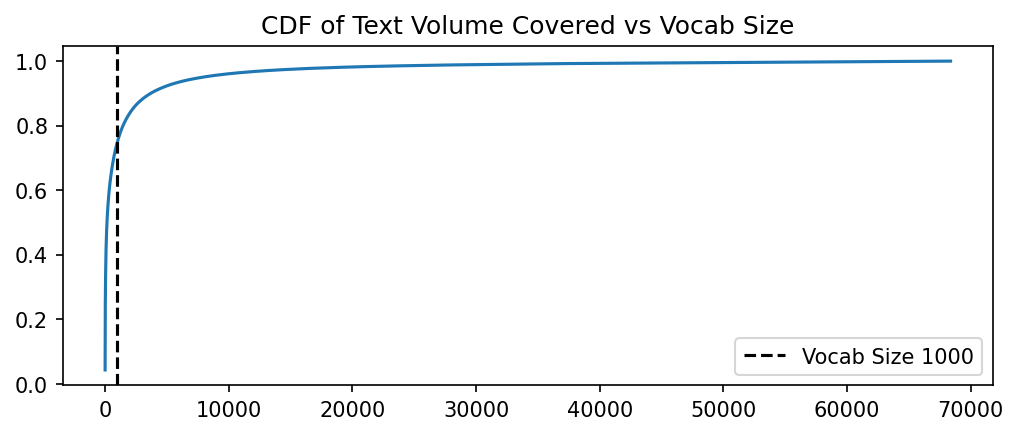

In [282]:
cdf = np.cumsum(np.sort(counts)[::-1]) / counts.sum()
print(cdf[1000])

plt.figure(figsize=(8, 3), dpi=150)
plt.title("CDF of Text Volume Covered vs Vocab Size")
plt.plot(cdf)
plt.axvline(1000, linestyle="--", c="black", label="Vocab Size 1000")
plt.legend()
plt.show()

# VAE Plots

In [75]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def get_metric(run_dir, metric):
    event_acc = EventAccumulator(run_dir)
    event_acc.Reload()
    train_times, train_steps, train_vals = zip(*event_acc.Scalars(f'train_{metric}'))
    val_times, val_steps, val_vals = zip(*event_acc.Scalars(f'val_{metric}'))
    val_vals = list(val_vals)
    for i in range(1, len(val_vals)):
        if val_vals[i] > 100:
            val_vals[i] = val_vals[i-1]
    return (train_steps, train_vals), (val_steps, val_vals)

def plot_metric(run_dir, metric):
    train_res, val_res = get_metric(run_dir, metric)
    fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), dpi=150)
    ax[0].set_title(f'Train {metric}')
    ax[0].plot(*train_res)
    ax[1].set_title(f'Val {metric}')
    ax[1].plot(*val_res)
    return ax

def show_posterior(posterior, label):
    print(f"True label: {label}")
    print(f"Predicted label: {posterior.argmax()} - with prob {posterior.max()}")

    barlist = plt.bar(range(len(posterior)), posterior)
    barlist[label].set_color('r')

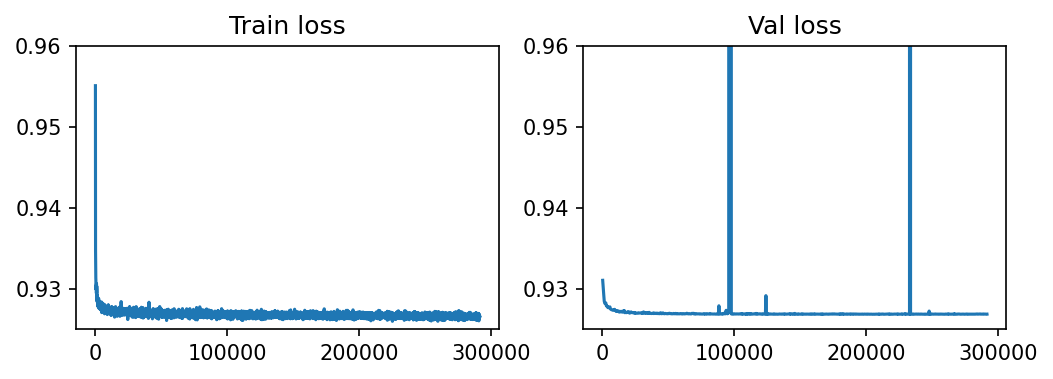

In [86]:
run_dir = 'experiments/lightning_logs/cifar10/lightning_logs/version_37'
ax = plot_metric(run_dir, 'loss')
ax[0].set_ylim(0.925, 0.96)
ax[1].set_ylim(0.925, 0.96)
plt.show()

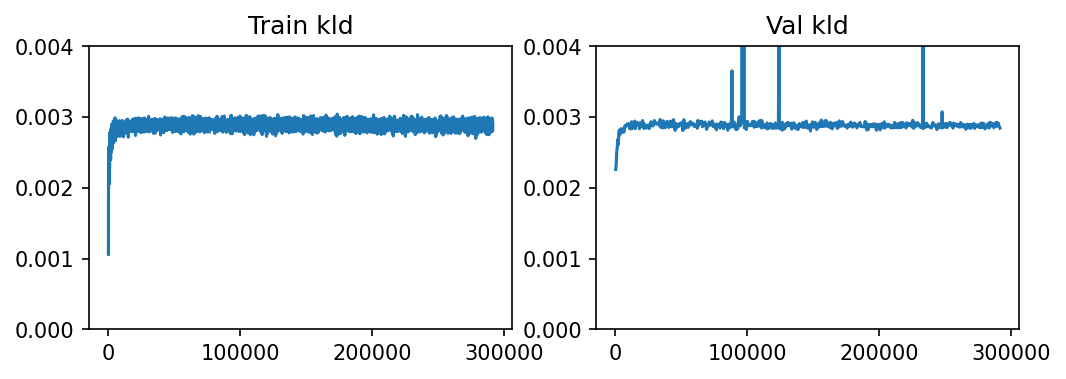

In [87]:
ax = plot_metric(run_dir, 'kld')
ax[0].set_ylim(0, 0.004)
ax[1].set_ylim(0, 0.004)
plt.show()

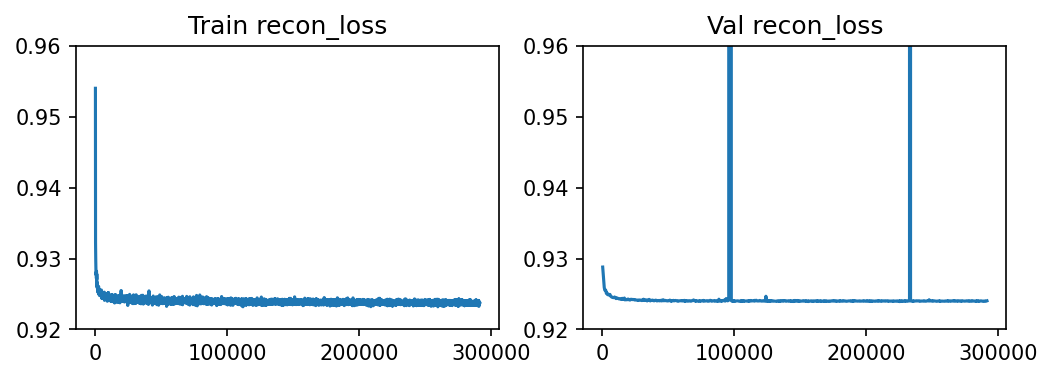

In [89]:
ax = plot_metric(run_dir, 'recon_loss')
ax[0].set_ylim(0.92, 0.96)
ax[1].set_ylim(0.92, 0.96)
plt.show()

# Text

In [4]:
dataset_name = "cleaned_categories10"

# Load datamodule
dm, vocab, label_ids = train.BOW_VAE.get_datamodule(dataset_name)
ds = dm.test_dataloader().dataset

## BOW Data Analysis and VAE Checks

In [68]:
# Load model
checkpoint_path = glob.glob(f"experiments/lightning_logs/{dataset_name}/lightning_logs/version_16/checkpoints/*.ckpt")[0]
net = train.BOW_VAE.get_backbone(xdims=len(vocab), category_dims=len(label_ids))
model = train.BOW_VAE.load_from_checkpoint(checkpoint_path, net=net, epochs=None, strict=False, map_location="cpu").cuda()
model.eval()
_ = model.requires_grad_(False)

In [27]:
inputs, labels = next(iter(dm.val_dataloader()))

In [233]:
#categories = ["POLITICS", "POLITICS", "TRAVEL", "TRAVEL", "WELLNESS", "WELLNESS"]
#categories = torch.tensor([label_ids.index(c) for c in categories])

#batch = []
#for c in categories:
#    valid_idxs = (ds.dataset.tensors[1][ds.indices] == c).nonzero()
#    idx = valid_idxs[torch.randint(len(valid_idxs), ())]
#    batch.append(ds[idx])
    
#inputs, labels = tuple(torch.stack(item) for item in zip(*batch))

In [234]:
reconstructed_samples = model.net(inputs.float().cuda(), labels.cuda())[0].sigmoid()

for i in range(min(len(reconstructed_samples), 3)):
    print("Class: ", label_ids[labels[i]])
    input_words = np.array(vocab)[inputs[i].nonzero().flatten()].tolist()
    recon_words = np.array(vocab)[torch.topk(reconstructed_samples[i].cpu(), len(input_words)).indices].tolist()
    matched = len(set(input_words).intersection(recon_words)) / len(input_words)
    print("Input: ", input_words)
    print("Recon: ", recon_words)
    print(f"Top-k Matched: {matched:.3f}\n")

Class:  misc.forsale
Input:  ['applic', 'approach', 'ask', 'big', 'book', 'buy', 'condit', 'date', 'distribut', 'email', 'fourth', 'gener', 'good', 'just', 'line', 'make', 'nntp-posting-host', 'offer', 'organ', 'page', 'probabl', 'problem', 'sale', 'send', 'smith', 'softwar', 'studi', 'subject', 'univers', 'usa', 'write']
Recon:  ['subject', 'line', 'organ', 'book', 'sale', 'condit', 'fourth', '21', 'e-mail', 'includ', 'offer', 'page', 'disk', 'new', 'price', 'ask', 'distribut', 'send', 'softwar', 'list', 'email', 'number', 'michael', 'refer', 'origin', 'work', 'copi', 'sell', 'packag', 'buy', 'purchas']
Top-k Matched: 0.484

Class:  talk.politics.guns
Input:  ['build', 'come', 'david', 'director', 'evid', 'law', 'leav', 'line', "n't", 'nntp-posting-host', 'organ', 'peopl', 'press', 'school', 'smith', 'start', 'statement', 'subject', 'think', 'univers', 'write']
Recon:  ['subject', 'line', 'organ', 'clinton', 'vote', 'state', 'repres', 'georg', 'univers', 'nntp-posting-host', 'law', 'b

In [235]:
categories = [0, 1, 2]
generated_samples = model.net.generate(torch.tensor(categories).cuda()).sigmoid()

for i in range(len(generated_samples)):
    print("Class: ", label_ids[categories[i]])
    print("Generated: ", np.array(vocab)[torch.topk(generated_samples[i].cpu(), 20).indices].tolist(), "\n")

Class:  alt.atheism
Generated:  ['subject', 'line', 'organ', '14', 'refer', 'post', 'lost', 'help', 'paul', 'write', 'john', 'posit', '13', "n't", 'ignor', 'know', 'question', 'did', 'document', 'group'] 

Class:  comp.graphics
Generated:  ['subject', 'line', 'organ', 'univers', '11', 'nntp-posting-host', 'know', 'keyword', 'distribut', 'thank', 'usa', 'file', 'reply-to', 'state', 'wrong', 'correct', 'georg', 'case', 'thought', 'just'] 

Class:  comp.os.ms-windows.misc
Generated:  ['subject', 'line', 'organ', 'articl', 'scienc', 'univers', 'previou', 'comput', '18', 'depart', 'reply-to', 'write', 'reserv', '13', 'game', 'germani', 'nntp-posting-host', 'email', 'cours', 'question'] 



## Decision Tree Baseline

In [42]:
train_X, train_Y = zip(*dm.train_dataloader())
train_X, train_Y = torch.cat(train_X), torch.cat(train_Y)

In [52]:
import sklearn.tree
import scipy.stats
import sklearn.model_selection

tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
distributions = dict(min_impurity_decrease=scipy.stats.loguniform(1e-6, 1e-1))
clf = sklearn.model_selection.RandomizedSearchCV(tree, distributions, cv=2, random_state=0, n_iter=10, verbose=2)
# search = clf.fit(train_X, train_Y)

In [19]:
tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy', random_state=0, min_impurity_decrease=1.5e-4)
tree.fit(train_X, train_Y)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.00015,
                       random_state=0)

In [20]:
test_X, test_Y = zip(*dm.test_dataloader())
test_X, test_Y = torch.cat(test_X), torch.cat(test_Y)

In [21]:
print(f"Accuracy: {tree.score(test_X, test_Y)}, Average depth: {tree.decision_path(test_X).sum(axis=1).mean()}")

Accuracy: 0.6299147234171006, Average depth: 76.1184061580258


## MAP Estimate Performance

In [81]:
p_y = torch.nn.functional.one_hot(torch.cat([y for _, y in dm.train_dataloader()])).float().mean(dim=0)
ds = dm.val_dataloader().dataset

def calc_posteriors(num_datapoints, num_samples, with_importance_sampling=True):
    posterior_results = {}
    rng = np.random.default_rng(64)
    for i in tqdm.tqdm(rng.choice(len(ds), size=num_datapoints, replace=False)):
        x, y = ds[i]
        posterior = map_estimate.calculate_posterior_full_history(model, x.cuda(), p_y, num_samples, batch_size=1024,
                                                                  with_importance_sampling=with_importance_sampling)
        posterior_results[i] = {'x': x, 'label': y, 'posterior': posterior}
    
    return posterior_results

posteriors = {num_samples: calc_posteriors(200, num_samples) for num_samples in [5000]}#[20, 100, 1000, 10000]}

In [55]:
def calc_accuracy(posterior_results):
    return np.mean([v['posterior'].argmax() == v['label'] for v in posterior_results.values()])

In [83]:
accs = {num_samples: calc_accuracy(p) for num_samples, p in posteriors.items()}
accs

{5000: 0.725}

In [56]:
posteriors = torch.load('experiments/map_posteriors/cleaned_categories10/final/posteriors.pth')
calc_accuracy(posteriors)

0.7172288883857822

In [ ]:
plt.figure(dpi=150)
plt.title("Text dataset accuracy vs. num monte carlo samples")
plt.plot(list(accs.keys()), list(accs.values()), '-o', label=r'beta = 1')
plt.plot([20, 100000], [0.707, 0.707], label='linear classifier')
plt.plot([20, 100000], [0.714, 0.714], label='two-layer MLP')
plt.ylabel('accuracy')
plt.xlabel('num monte carlo samples')
plt.xscale('log')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3), dpi=150)
plt.title(r"$p(y | B_{x,k})$ accuracy where 1/10 of queries are positive")
plt.plot(list(accs_rand.keys()), list(accs_rand.values()), '-o')
plt.ylabel('accuracy')
plt.xlabel('number of queries revealed (out of 1000 total)')
plt.locator_params(axis='x', nbins=20)
#plt.xscale('log')
#plt.legend()
plt.ylim(0, None)
plt.show()

## Information Pursuit

In [9]:
ip_dir = f'experiments/ip/{dataset_name}/final'
save_data = {int(pathlib.Path(f).stem): torch.load(f, map_location=torch.device("cpu"))
              for f in tqdm.tqdm(glob.glob(f'{ip_dir}/*.pth'))}

  0%|          | 0/13251 [00:00<?, ?it/s]

In [11]:
text_save_data = save_data
# save_data = text_save_data

In [5]:
with open(f'{ip_dir}/hyperparams.yaml') as f:
    hyperparams = yaml.load(f, Loader=yaml.Loader)
hyperparams

{'batch_size': 1024,
 'checkpoint_path': 'experiments/lightning_logs/cleaned_categories10/lightning_logs/final/checkpoints/epoch=149-step=31199.ckpt',
 'patch_size': None,
 'query_strategy': 'ip',
 'stopping_criterion': {'num_steps': 1000},
 'ula_samples': 25000}

In [150]:
mi_thresholds = np.logspace(-3.5, -2.5, num=50)
num_queries = queries_to_mi(save_data, mi_thresholds)
accuracies = accuracy_at_mi(save_data, mi_thresholds)

In [99]:
accuracies.max(), mi_thresholds[accuracies.argmax()]

(tensor(0.7150), 0.00031622776601683794)

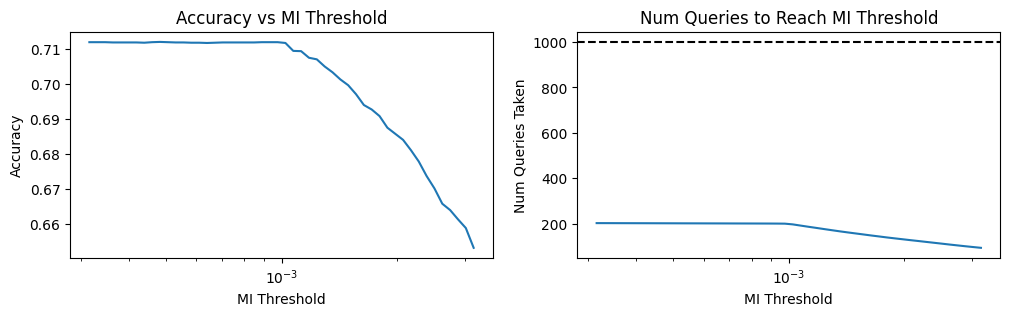

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3), dpi=100)
ax[0].set_title('Accuracy vs MI Threshold')
ax[0].plot(mi_thresholds, accuracies)
ax[0].set_xlabel('MI Threshold')
ax[0].set_ylabel('Accuracy')
ax[0].set_xscale('log')

ax[1].set_title('Num Queries to Reach MI Threshold')
ax[1].plot(mi_thresholds, num_queries.float().mean(dim=0))
ax[1].axhline(1000, linestyle='--', color='black')
ax[1].set_xlabel('MI Threshold')
ax[1].set_ylabel('Num Queries Taken')
ax[1].set_xscale('log')
plt.show()

In [10]:
df = pd.read_json("data/doc_classification/News_Category_Dataset_Cleaned_Categories10.json", lines=True)
df["Text"] = df["headline"] + ". " + df["short_description"]

In [17]:
idx = 256 #[0, 2, 3][2]
sample = save_data[idx]
x, y = ds[idx]
" ".join(np.array(vocab)[x.nonzero()].squeeze()), label_ids[y]

("ask bar citi drink easi eat industri n't new restaur sleep visit york",
 'TRAVEL')

In [102]:
import functools

def get_sentence_row(words):
    bools = [df["Text"].str.lower().str.contains(w) for w in words]
    return df[functools.reduce(lambda a, b: a & b, bools)]

words = [["ice", "like", "look", "new", "trailer", "goe"],
         ["chang", "check", "cute", "kardashian"],
         ["chang", "know", "life", "race", "reflect", "star"]][2] # ["ask", "bar", "york", "eat"]
sentence = get_sentence_row(words)
print(len(sentence))

headline = sentence.iloc[0]["headline"]
short_description = sentence.iloc[0]["short_description"]
headline, short_description, label_ids[y]

1


('Last Words: Ginger Minj Reflects On ‘RuPaul’s All Stars Drag Race’',
 '"I don’t know if it changed me, but it changed my life."',
 'QUEER VOICES')

In [103]:
padding = 2
post_kld = scipy.special.kl_div(sample['log_posteriors'][padding+1:-(padding-1)].exp(),
                                sample['log_posteriors'][padding:-padding].exp()).sum(dim=1)
num_vals = min(20 - 2 * padding, len(post_kld))
idxs = torch.tensor([True] * (padding+1) + (post_kld > post_kld.sort().values[-num_vals]).tolist() + [True] * (padding-1))

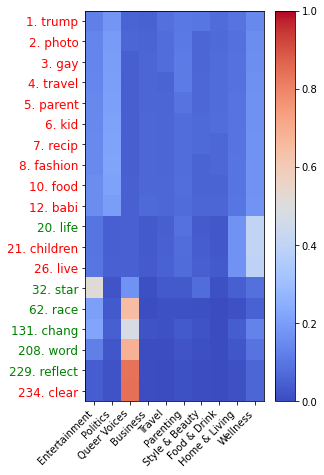

In [91]:
import textwrap

labels_nice = labels = ["Entertainment", "Politics", "Queer Voices", "Business", "Travel", "Parenting", "Style & Beauty",
                        "Food & Drink", "Home & Living", "Wellness"]

plt.figure(figsize=(4, 7))
plt.matshow(sample['log_posteriors'][idxs].exp(), cmap='coolwarm', vmin=0, vmax=1, fignum=1, aspect='auto', interpolation='nearest')
# plt.figtext(0.405, 1.17, "Category:", fontsize='large', ha='center', weight='bold')
# plt.figtext(0.595, 1.17, "Travel", fontsize='large', ha='center')
# plt.figtext(0, 1.13, "Headline: ", fontsize='large', ha='left', weight='bold')
# plt.figtext(0, 1.1, "\n".join(textwrap.wrap("                  " + headline, 45)), fontsize='large', ha='left')
# plt.figtext(0, 1.04, "Short description: ", fontsize='large', ha='left', weight='bold')
# plt.figtext(0, 0.88, "\n".join(textwrap.wrap("                                 " + short_description, 45)), 
# fontsize='large', ha='left')
plt.colorbar()

queries = [f"{i + 1}. {vocab[q]}" for i, q in enumerate(sample['query_order']) if idxs[i]]
plt.yticks(range(idxs.count_nonzero()), labels=queries, fontsize=12)
for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color("green" if x[torch.tensor(sample['query_order'])[idxs][i]] else "red")

plt.gca().xaxis.tick_bottom()
plt.xticks(range(10), labels_nice, rotation=45, ha='right')
# plt.savefig("IP_in_action_HuffPost3.pdf", bbox_inches='tight')
plt.show()

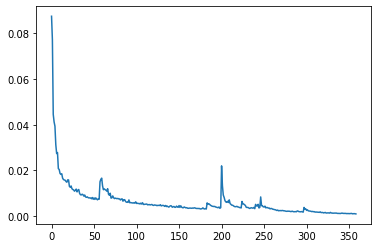

In [154]:
plt.plot([ms.amax() for ms in sample['mutual_information']])

In [418]:
mi_thresholds = np.logspace(-15, -1, num=50)[::-1].copy()
ses = queries_to_mi(save_data, mi_thresholds).float().mean(dim=0)
accuracies = accuracy_at_mi(save_data, mi_thresholds)

In [430]:
idx = 7
mi_thresholds[idx], ses[idx], accuracies[idx]

(0.001, tensor(199.3649), tensor(0.7121))

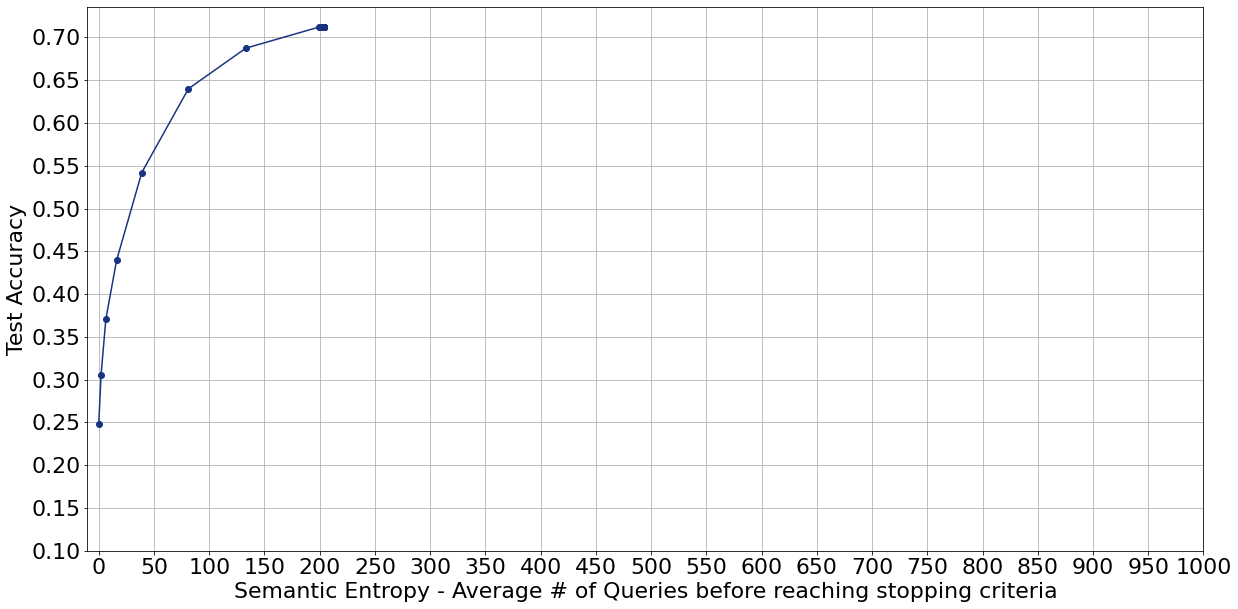

In [419]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.plot(ses, accuracies, '-o', color=(0.1, 0.2, 0.5), )
plt.xlabel("Semantic Entropy - Average # of Queries before reaching stopping criteria")
plt.ylabel("Test Accuracy")
plt.grid()
plt.xticks(np.arange(0, 1001, step=50))
plt.yticks(np.arange(0.1, 0.75, step=0.05))
# plt.legend()
plt.show()

In [40]:
def plot_most_informative_words(save_data):
    avg = np.zeros((10, 1000))
    num_sentences = np.zeros((10,))
    for ind, data in save_data.items():
        x, y = ds[ind]
        num_sentences[y] += 1
        if 'query_order' in data:
            last_query = (torch.stack(data['mutual_information']).amax(dim=1) < 1e-3).long().argmax()
            for query in data['query_order'][:last_query]:
                avg[y][query] += 1
               
    #print(avg.max(), num_sentences.max())
    avg = avg / num_sentences[:, None]
    avg = avg / avg.max(axis=1, keepdims=True)
    
    for y in range(len(avg)):
        print(label_ids[y])
        argsorted = avg[y].argsort()[::-1]
        for w in argsorted[:10]:
            print(vocab[w], avg[y][w])
        print()
        
plot_most_informative_words(save_data)

ENTERTAINMENT
trump 1.0
gay 0.9993618379068283
photo 0.9968091895341417
fashion 0.9968091895341417
queer 0.98851308232291
parent 0.9853222718570517
star 0.9853222718570517
food 0.98468410976388
tran 0.97702616464582
republican 0.9744735162731334

POLITICS
trump 1.0
gay 1.0
photo 0.9960498328775449
fashion 0.986934062594956
lgbtq 0.9772105742935278
republican 0.9434822242479489
food 0.932847158918262
queer 0.932847158918262
democrat 0.9191735034943787
tran 0.8930416286842905

QUEER VOICES
gay 1.0
trump 1.0
queer 0.9936406995230525
photo 0.9841017488076311
lgbt 0.9777424483306836
lgbtq 0.9554848966613673
travel 0.9538950715421304
tran 0.9411764705882353
parent 0.9332273449920508
transgend 0.9236883942766295

BUSINESS
photo 1.0
trump 1.0
fashion 1.0
gay 1.0
travel 0.9948717948717949
food 0.9948717948717949
health 0.9931623931623932
republican 0.9914529914529915
kid 0.9914529914529915
parent 0.9914529914529915

TRAVEL
photo 1.0
trump 1.0
travel 0.9989909182643795
hotel 0.9808274470232089
g

# Binary Image Datasets

In [26]:
# Load data
dataset_name = "mnist"

dm = train.BinaryImageVAE.get_datamodule(dataset_name)
label_ids = dm.val_dataloader().dataset.classes
ds = dm.val_dataloader().dataset
inputs, labels = next(iter(dm.val_dataloader()))

## Data Analysis and VAE Checks

In [20]:
# Load model
checkpoint_path = glob.glob(f"experiments/lightning_logs/{dataset_name}/lightning_logs/final/checkpoints/*.ckpt")[0]
net = train.BinaryImageVAE.get_backbone(dataset_name)
model = train.BinaryImageVAE.load_from_checkpoint(checkpoint_path, net=net, epochs=None, strict=True, map_location="cpu")
model.eval()
model.to(map_estimate.device)
_ = model.requires_grad_(False)

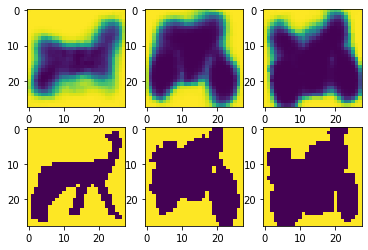

In [68]:
# Check reconstructions
reconstructed_imgs = model.net(inputs.float().cuda(), labels.cuda())[0].sigmoid()

fig, ax = plt.subplots(2, 3)
for i in range(ax.shape[1]):
    ax[0, i].imshow(reconstructed_imgs[i].squeeze().detach().cpu())
    ax[1, i].imshow(inputs[i].squeeze())
plt.show()

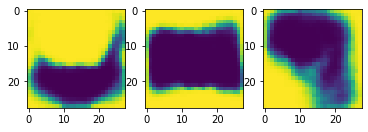

In [69]:
# Check generated images
gen_imgs = model.net.generate(torch.tensor([0, 3, 7]).cuda()).sigmoid()

fig, ax = plt.subplots(1, 3)
for i in range(len(ax)):
    ax[i].imshow(gen_imgs[i].squeeze().detach().cpu())
plt.show()

## Decision Tree Baseline

In [ ]:
patch_size = 3

def image_to_patch_identities(train_X):
    train_X = train_X.squeeze(1).unfold(1, patch_size, 1).unfold(2, patch_size, 1).flatten(start_dim=-2)
    all_patterns = torch.tensor(list(itertools.product([0, 1], repeat=patch_size * patch_size))).T

    processed_X = []
    batch_size = 512
    for i in tqdm.trange(0, len(train_X), batch_size):
        patterns_matched = (train_X[i:i+batch_size].unsqueeze(-1) == all_patterns).all(dim=-2)
        processed_X.append(patterns_matched.long().argmax(dim=-1).flatten(start_dim=1))

    return torch.cat(processed_X)

In [185]:
train_X, train_Y = zip(*dm.train_dataloader())
train_X = image_to_patch_identities(torch.cat(train_X))
train_Y = torch.cat(train_Y)

test_X, test_Y = zip(*dm.val_dataloader())
test_X = image_to_patch_identities(torch.cat(test_X))
test_Y = torch.cat(test_Y)

In [186]:
# Hyperparameter search to find best MI stopping criteria for decision tree

import sklearn.tree
import scipy.stats
import sklearn.model_selection

tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
distributions = dict(min_impurity_decrease=scipy.stats.loguniform(1e-7, 1e-1))
clf = sklearn.model_selection.RandomizedSearchCV(tree, distributions, cv=2, random_state=0, n_iter=10, verbose=2)
search = clf.fit(train_X, train_Y)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END .........min_impurity_decrease=0.000196282248134428; total time=  16.7s
[CV] END .........min_impurity_decrease=0.000196282248134428; total time=  16.6s
[CV] END ........min_impurity_decrease=0.0019549524484259876; total time=  12.7s
[CV] END ........min_impurity_decrease=0.0019549524484259876; total time=  12.5s
[CV] END ........min_impurity_decrease=0.0004135997393839892; total time=  16.4s
[CV] END ........min_impurity_decrease=0.0004135997393839892; total time=  16.2s
[CV] END .......min_impurity_decrease=0.00018590843630169633; total time=  17.6s
[CV] END .......min_impurity_decrease=0.00018590843630169633; total time=  16.6s
[CV] END .......min_impurity_decrease=3.4828020870283304e-05; total time=  16.7s
[CV] END .......min_impurity_decrease=3.4828020870283304e-05; total time=  16.7s
[CV] END ........min_impurity_decrease=0.0007505241622349542; total time=  15.3s
[CV] END ........min_impurity_decrease=0.0007505

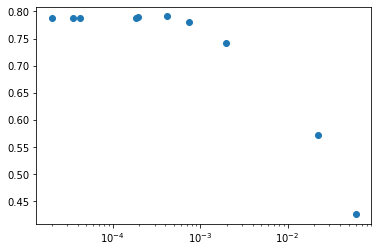

In [187]:
plt.scatter(search.cv_results_['param_min_impurity_decrease'].data, search.cv_results_['mean_test_score'])
plt.xscale('log')
plt.show()

In [194]:
# Now we actually fit the tree with this hyperparameter
tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy', random_state=1, min_impurity_decrease=1e-4)
_ = tree.fit(train_X, train_Y)

In [195]:
print(f"Accuracy: {tree.score(test_X, test_Y)}, Average depth: {tree.decision_path(test_X).sum(axis=1).mean()}")

Accuracy: 0.6888, Average depth: 13.8575


## MAP Estimate Performance

In [236]:
ys = torch.cat([batch[1] for batch in itertools.islice(dm.train_dataloader(), 1000)])
p_y = torch.histc(ys.float(), bins=len(ys.unique())) / len(ys)

In [77]:
ds = dm.val_dataloader().dataset

def posterior_accuracy(num_datapoints, num_samples, with_importance_sampling=True):
    posterior_results = []
    for i in tqdm.trange(num_datapoints):
        x, y = ds[i]
        posterior = map_estimate.calculate_posterior_full_history(model, x.cuda(), p_y, num_samples_per_y=num_samples,
                                                                  with_importance_sampling=with_importance_sampling)
        posterior_results.append((x, y, posterior))
        
    return np.mean([p.argmax() == y for x, y, p in posterior_results]), posterior_results

In [78]:
accs = {num_samples: posterior_accuracy(200, num_samples)[0] for num_samples in [1000]}#[20, 100, 1000, 5000]}

100%|██████████| 200/200 [19:21<00:00,  5.81s/it]


In [80]:
accs

{1200: 0.705}

In [53]:
posteriors = torch.load('experiments/map_posteriors/fashion_mnist/run_0/posteriors.pth')
torch.tensor([res['label'] == res['posterior'].argmax() for res in posteriors.values()]).float().mean()

tensor(0.8756)

In [12]:
plt.title("Accuracy vs. num monte carlo samples")
plt.plot(list(accs.keys()), list(accs.values()), label="without IS")
plt.plot(list(accs_with_is.keys()), list(accs_with_is.values()), label="with IS")
plt.legend()
plt.show()

## Information Pursuit

In [140]:
ip_dir = "experiments/ip/mnist/final_1x1"
save_data = {int(pathlib.Path(f).stem): torch.load(f, map_location=torch.device("cpu"))
              for f in tqdm.tqdm(glob.glob(f"{ip_dir}/*.pth"))}

  0%|          | 0/10000 [00:00<?, ?it/s]

In [171]:
# fmnist_save_data = save_data
# save_data = fmnist_save_data

In [67]:
with open(f"{ip_dir}/hyperparams.yaml") as f:
    hyperparams = yaml.load(f)
hyperparams

/cis/home/sslocum/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 256,
 'checkpoint_path': 'experiments/lightning_logs/mnist/lightning_logs/version_4/checkpoints/epoch=186-step=87702.ckpt',
 'patch_size': 4,
 'query_strategy': 'ip',
 'stopping_criterion': {'confidence': 0.99, 'num_steps': 676},
 'ula_samples': 2000}

In [11]:
p_y = torch.cat([torch.nn.functional.one_hot(y, 10) for _, y in dm.train_dataloader()]).float().mean(dim=0)

In [137]:
labels = []
preds = []
explanation_lengths = []
for i, data in save_data.items():
    x, y = ds[i]
    if 'log_posteriors' in data and data['log_posteriors'][-1].exp().amax() > 0.99:
        pred = data['log_posteriors'][-1].argmax()
        preds.append(pred)
        labels.append(y)
        explanation_lengths.append(len(data['query_order']))
    
labels, preds = torch.tensor(labels), torch.tensor(preds)
avg_explanation_length = np.mean(explanation_lengths)

In [140]:
print("Accuracy: ", (preds == labels).float().mean().item())
print("Average Explanation Length: ", avg_explanation_length)
print("epsilon: ", hyperparams['stopping_criterion']['confidence'])

Accuracy:  0.854025661945343
Average Explanation Length:  18.10465703606425


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-140-1095eeeb5385>:3 in <module>                                            │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'confidence'

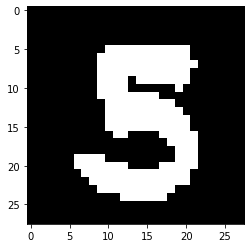

In [46]:
plt.imshow(ds[1003][0].squeeze(), cmap='gray')
plt.show()

In [178]:
mnist_img_idx = 100 # [10, 14, 15] # 9
fmnist_img_idx = 5 # [0, 1, 3]
kmnist_img_idx = 10 # [10, 11, 12]

img_idx = 3

In [179]:
padding = 2
post_kld = scipy.special.kl_div(save_data[img_idx]['log_posteriors'][padding+1:-(padding-1)].exp(),
                                save_data[img_idx]['log_posteriors'][padding:-padding].exp()).sum(dim=1)
num_vals = min(10 - 2 * padding, len(post_kld))
idxs = torch.tensor([True] * (padding+1) + (post_kld > post_kld.sort().values[-num_vals]).tolist() + [True] * (padding-1))
#idxs = torch.tensor([True] * len(save_data[img_idx]['log_posteriors']))

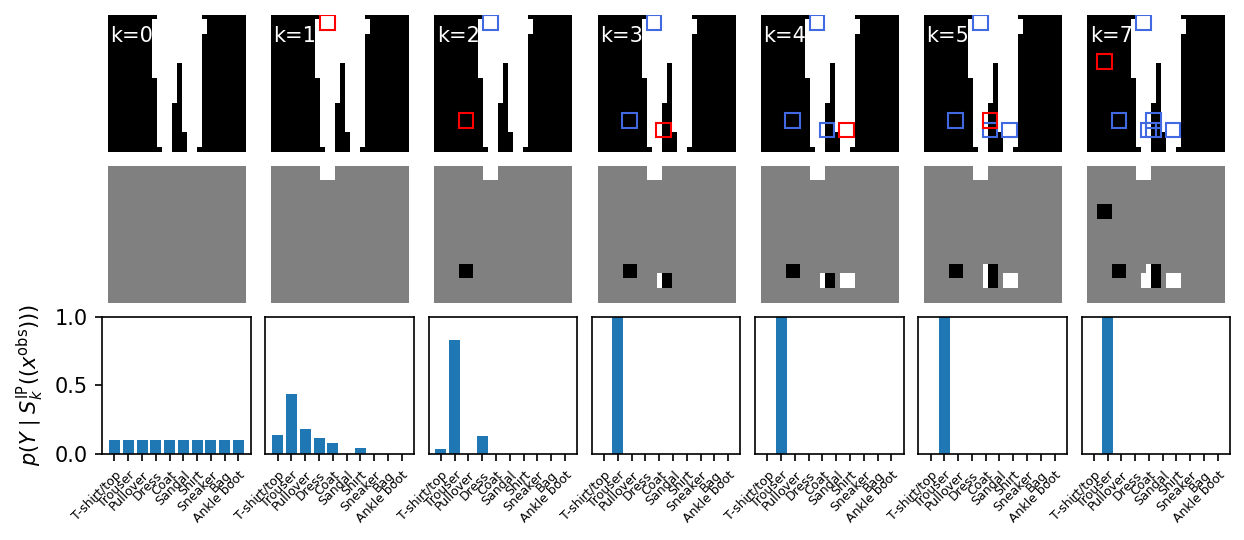

In [180]:
x, y = ds[img_idx]
patch_size = 3

fig, ax = plt.subplots(3, idxs.count_nonzero().item(), figsize=(6 / 5 * idxs.count_nonzero().item(), 3.7), dpi=150)
# fig.suptitle("Shirt")
for i in range(ax.shape[1]):
    ax[0, i].axis('off')
    ax[0, i].imshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    ax[0, i].text(0, 5, f'k={np.arange(len(idxs))[idxs][i]}', color='white')
    # ax[0, i].set_title(f'k={np.arange(len(idxs))[idxs][i]}')
    
    visible_x = torch.zeros_like(x.squeeze()) + 0.5
    for k in range(idxs.nonzero()[i]):
        qy, qx = save_data[img_idx]['query_order'][k]
        color = 'r' if k == i - 1 else 'royalblue'
        rect = matplotlib.patches.Rectangle((qx-0.5, qy-0.5), patch_size, patch_size, linewidth=1, edgecolor=color, facecolor='none')
        ax[0, i].add_patch(rect)
        visible_x[qy:qy+patch_size, qx:qx+patch_size] = x[0, qy:qy+patch_size, qx:qx+patch_size]
    
    ax[1, i].axis('off')
    ax[1, i].imshow(visible_x, cmap='gray', vmin=0, vmax=1)
    
    ax[2, i].bar(range(10), save_data[img_idx]['log_posteriors'][idxs][i].exp())
    if i == 0:
        ax[2, 0].set_ylabel(r'$p(Y \mid S^{\mathrm{IP}}_k((x^{\mathrm{obs}})))$')
        ax[2, 0].set_yticks([0, 0.5, 1])
    else:
        ax[2, i].tick_params(left=False, labelleft=False)
    ax[2, i].set_xticks(range(10), labels=ds.classes)
    #ax[2, i].set_xticklabels(range(10), fontsize=10)
    ax[2, i].set_xticklabels(ds.classes, rotation=45, ha='right', rotation_mode='anchor', fontsize=6)
    ax[2, i].set_ylim(0, 1)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("IP_in_action_FashionMNIST3.pdf", bbox_inches='tight')
plt.show()

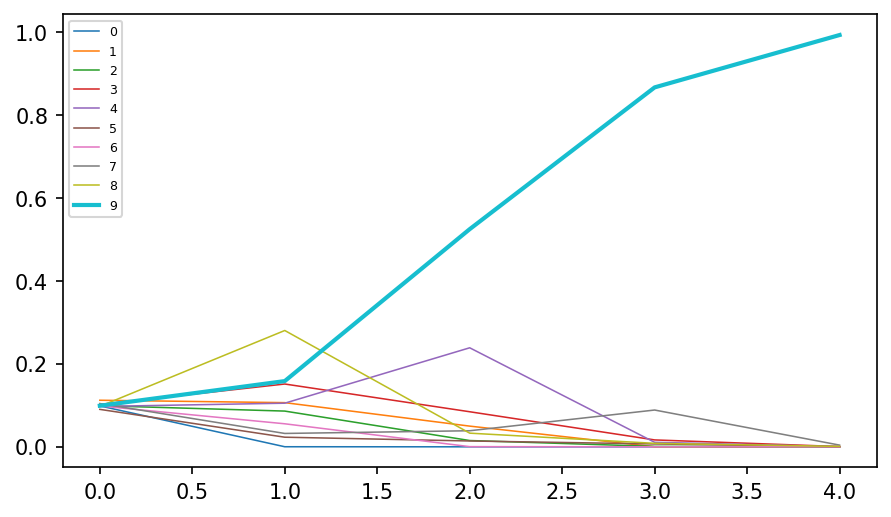

In [87]:
plt.figure(figsize=(7, 4), dpi=150)
for i in range(len(label_ids)):
    plt.plot(save_data[img_idx]['log_posteriors'].exp()[:, i], label=i, linewidth=2 if i == y else 0.75)
plt.legend(loc=0, fontsize=6)
plt.show()

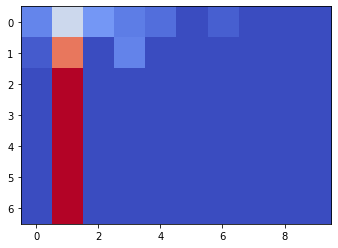

In [18]:
plt.imshow(save_data[img_idx]['log_posteriors'].exp(), cmap='coolwarm', vmin=0, vmax=1)
plt.show()

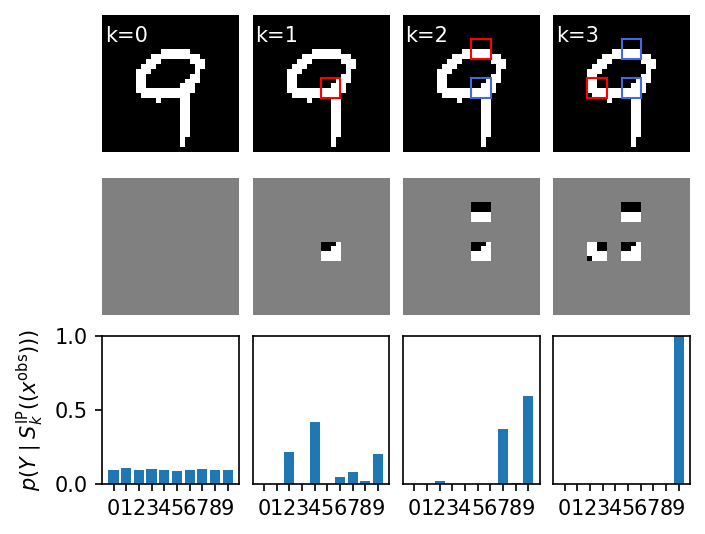

In [67]:
save_data = mnist4x4_save_data
patch_size = 4
img_idx = 105 # 103

x, y = ds[img_idx]
queries = range(len(save_data[img_idx]['query_order']) + 1)

fig, ax = plt.subplots(3, len(queries), figsize=(6 / 5 * len(queries), 3.7), dpi=150)
for i in range(ax.shape[1]):
    ax[0, i].axis('off')
    ax[0, i].imshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    ax[0, i].text(0, 5, f'k={queries[i]}', color='white')
    
    visible_x = torch.zeros_like(x.squeeze()) + 0.5
    for k in range(queries[i]):
        qy, qx = save_data[img_idx]['query_order'][k]
        color = 'r' if k == queries[i] - 1 else 'royalblue'
        rect = matplotlib.patches.Rectangle((qx-0.5, qy-0.5), patch_size, patch_size, linewidth=1,
                                            edgecolor=color, facecolor='none')
        ax[0, i].add_patch(rect)
        visible_x[qy:qy+patch_size, qx:qx+patch_size] = x[0, qy:qy+patch_size, qx:qx+patch_size]
    
    ax[1, i].axis('off')
    ax[1, i].imshow(visible_x, cmap='gray', vmin=0, vmax=1)
    
    ax[2, i].bar(range(10), save_data[img_idx]['log_posteriors'][i].exp())
    if i == 0:
        ax[2, 0].set_ylabel(r'$p(Y \mid S^{\mathrm{IP}}_k((x^{\mathrm{obs}})))$')
        ax[2, 0].set_yticks([0, 0.5, 1])
    else:
        ax[2, i].tick_params(left=False, labelleft=False)
    ax[2, i].set_xticks(range(10))
    ax[2, i].set_ylim(0, 1)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.savefig("IP_in_action_MNIST_4x4.pdf", bbox_inches='tight')
plt.show()

# CUB

In [18]:
train_ds, val_ds, test_ds = utils.get_data("cub_xyc")
ds = test_ds

## Concept Network Checks

First we train a linear classifier to predict the type of bird, given the concept outputs of a concept network. This gives a sense of a good accuracy we could achieve with IP using the concept network.

In [10]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

In [79]:
train_c_hat, train_y = zip(*[(model.net(x), y) for x, y, c in tqdm.tqdm(train_dl)])
train_c_hat, train_y = torch.cat(train_c_hat), torch.cat(train_y)

In [82]:
import sklearn.linear_model

train_c_hat_preds = (train_c_hat > 0).float()
clf = sklearn.linear_model.LogisticRegression(random_state=0).fit(train_c_hat.numpy(), train_y.numpy())

/cis/home/sslocum/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [83]:
val_c_hat, val_y = zip(*[(model.net(x), y) for x, y, c in tqdm.tqdm(val_dl)])
val_c_hat, val_y = torch.cat(val_c_hat), torch.cat(val_y)

In [84]:
(clf.predict(val_c_hat) == val_y.numpy()).mean()

0.5792988313856428

In [56]:
train_c, train_y1 = zip(*[(c, y) for x, y, c in tqdm.tqdm(train_dl)])
train_c, train_y1 = torch.cat(train_c), torch.cat(train_y1)

In [ ]:
test_c, test_y1 = zip(*[(c, y) for x, y, c in tqdm.tqdm(test_dl)])
test_c, test_y1 = torch.cat(test_c), torch.cat(test_y1)

In [87]:
clf1 = sklearn.linear_model.LogisticRegression(random_state=0).fit(train_c.numpy(), train_y1.numpy())

/cis/home/sslocum/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [62]:
import sklearn.tree

tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy', random_state=0, min_impurity_decrease=1e-6)
tree.fit(train_c, train_y1)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=1e-06,
                       random_state=0)

In [63]:
tree.score(test_c, test_y1)

1.0

In [64]:
train_x, train_y2 = zip(*[(c, y) for x, y, c in tqdm.tqdm(train_dl)])
train_x, train_y2 = torch.cat(train_x), torch.cat(train_y2)

test_x, test_y2 = zip(*[(c, y) for x, y, c in tqdm.tqdm(test_dl)])
test_x, test_y2 = torch.cat(test_x), torch.cat(test_y2)

In [65]:
tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy', random_state=0, min_impurity_decrease=1e-6)
tree.fit(train_x, train_y2)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=1e-06,
                       random_state=0)

In [66]:
tree.score(test_x, test_y2)

1.0

## Decision Tree Baseline

In [5]:
# Configuration variables
checkpoint_path = glob.glob(f"experiments/lightning_logs/cub_concept_net/lightning_logs/version_12/checkpoints/*.ckpt")[0]

In [42]:
# Load datamodule
dm = train.CUB_VAE.get_datamodule(use_noisy_answer=True)

In [40]:
# Load model
# model = train.SupervisedCUBModel.load_from_checkpoint(checkpoint_path, arch="mlp")
model = train.CUBConceptModel.load_from_checkpoint(checkpoint_path)
model.eval()
model.requires_grad_(False)
_ = model.cuda()

In [57]:
train_c_preds = []
train_y = []
for x, y, c in tqdm.tqdm(dm.train_dataloader()):
    train_c_preds.extend(model.net(x.cuda()).cpu())
    train_y.extend(y)
train_c_preds = torch.stack(train_c_preds)
train_y = torch.stack(train_y)

val_c_preds = []
val_y = []
for x, y, c in tqdm.tqdm(dm.val_dataloader()):
    val_c_preds.extend(model.net(x.cuda()).cpu())
    val_y.extend(y)
val_c_preds = torch.stack(val_c_preds)
val_y = torch.stack(val_y)

In [ ]:
import sklearn.tree
import scipy.stats
import sklearn.model_selection

tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
distributions = dict(min_impurity_decrease=scipy.stats.loguniform(1e-10, 1e-1))
clf = sklearn.model_selection.RandomizedSearchCV(tree, distributions, cv=2, random_state=0, n_iter=10, verbose=2)
search = clf.fit(train_c_preds, train_y)

In [ ]:
plt.scatter(search.cv_results_['param_min_impurity_decrease'].data, search.cv_results_['mean_test_score'])
plt.xscale('log')
plt.show()

In [58]:
import sklearn.tree

tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy', random_state=0, min_impurity_decrease=1e-3)
tree.fit(train_c_preds, train_y)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.001,
                       random_state=0)

In [59]:
tree.score(val_c_preds, val_y)

0.2988313856427379

## Information Pursuit

In [19]:
ip_dir = "experiments/ip/cub_concepts/final"
save_data = {int(pathlib.Path(f).stem): torch.load(f, map_location=torch.device("cpu"))
              for f in tqdm.tqdm(glob.glob(f"{ip_dir}/*.pth"))}

  0%|          | 0/5794 [00:00<?, ?it/s]

In [6]:
# cub_save_data = save_data
# save_data = cub_save_data

In [143]:
with open(f"{ip_dir}/hyperparams.yaml") as f:
    hyperparams = yaml.load(f)
hyperparams

/cis/home/sslocum/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 256,
 'checkpoint_path': 'experiments/lightning_logs/cub/lightning_logs/version_14/checkpoints/epoch=1710-val_loss=0.04.ckpt',
 'patch_size': 1,
 'query_strategy': 'ip',
 'stopping_criterion': {'mutual_information': 1e-06, 'num_steps': 312},
 'ula_samples': 12000}

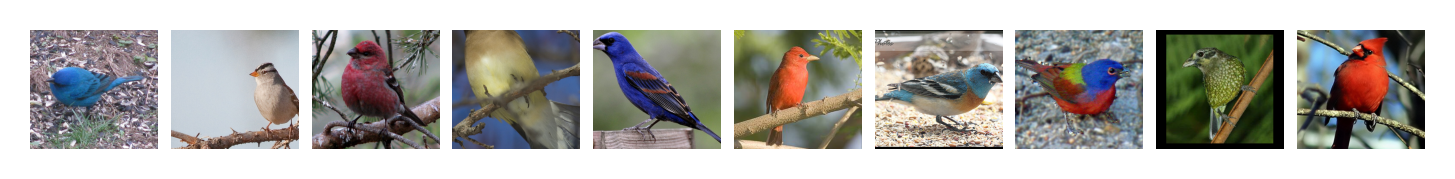

In [8]:
def samples_from_class(c, rng, num_samples=1):
    samples = []
    while len(samples) < num_samples:
        x, y, _ = ds[rng.integers(len(ds))]
        if y == c:
            samples.append((x, y))
            
    return samples[0] if num_samples == 1 else samples

rng = np.random.default_rng(41)
class_examples = {c.item(): samples_from_class(c, rng)[0].permute(1, 2, 0).numpy() * 2 + 0.5 for c in top_classes}

c = top_classes[3].item()
fig, ax = plt.subplots(1, 10, dpi=300)
for i, c in enumerate(top_classes):
    ax[i].axis('off')
    ax[i].imshow(class_examples[c.item()][10:-10])
    
plt.subplots_adjust(wspace=0.1)
plt.savefig("Top CUB classes0.pdf")
plt.show()

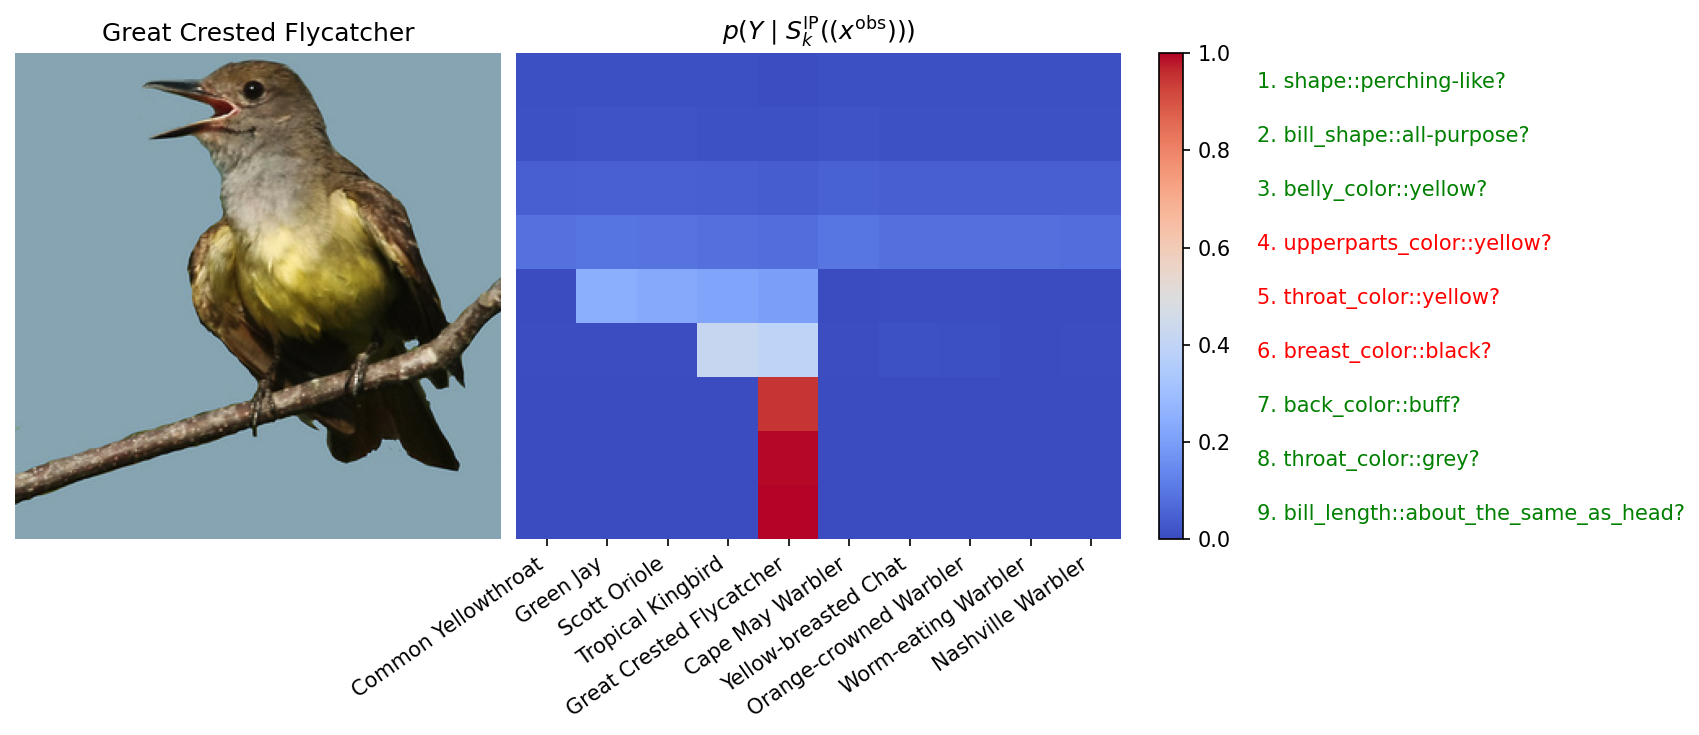

In [25]:
img_idx = 1001 # [1, 102, 2321][1] # 1001
x, y, c = ds[img_idx]
stop_i = (torch.stack(save_data[img_idx]['mutual_information']).amax(dim=1) <= 0.05).long().argmax()
# print(stop_i)

fig, ax = plt.subplots(1, 2, figsize=(11.5, 5), dpi=150, gridspec_kw={'width_ratios': [2, 3]})
ax[0].set_title(ds.classes[y])
ax[0].imshow(x.permute(1, 2, 0) * 2 + 0.5)
ax[0].axis('off')

# 200 classes make heatmap hard to read, so only show top few classes
mat = save_data[img_idx]['log_posteriors'][:stop_i+1].exp()
top_classes = mat.amax(dim=0).topk(k=10, sorted=False).indices
mat = mat[:, top_classes]

ax[1].set_title(r"$p(Y \mid S^{\mathrm{IP}}_k((x^{\mathrm{obs}})))$")
cax = ax[1].matshow(mat, cmap='coolwarm', vmin=0, vmax=1, aspect='auto')
fig.colorbar(cax)
ax[1].set_yticks(range(stop_i + 1))
ax[1].set_yticklabels([f"{i+1}. {ds.attributes[q][4:]}?" # {'Yes' if c[q] else 'No'}"
                       for i, q in enumerate(save_data[img_idx]['query_order'][:stop_i+1])], x=1.2)
ax[1].yaxis.tick_right()
for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color("green" if c[save_data[img_idx]['query_order'][i]] else "red")

# ax[1].set_ylabel("Query at iteration k")
# ax[1].yaxis.set_label_position("right")
ax[1].set_xticks(range(len(top_classes)))
ax[1].set_xticklabels([ds.classes[c] for c in top_classes], rotation=35, ha='right')#, y=-0.13)
ax[1].xaxis.tick_bottom()
ax[1].tick_params(right=False)
for s in ax[1].spines.values():
    s.set_visible(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.01)
# plt.savefig("figures/IP_in_action_CUB0.pdf")
plt.show()

In [ ]:
# i = 24
mi_thresholds[i], num_queries[i], accuracies[i]

In [226]:
mi_thresholds = np.logspace(-3, 0, num=50)
num_queries = queries_to_mi(save_data, mi_thresholds).float().mean(dim=0)
accuracies = accuracy_at_mi(save_data, mi_thresholds)

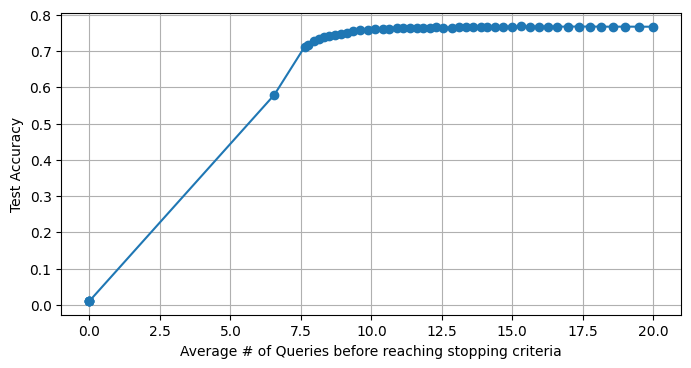

In [227]:
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(num_queries, accuracies, '-o')
plt.xlabel("Average # of Queries before reaching stopping criteria")
plt.ylabel("Test Accuracy")
plt.grid()
# plt.legend()
plt.show()

In [181]:
len(mnist_save_data), len(kmnist_save_data), len(fmnist_save_data), len(cub_save_data), len(text_save_data)

(10000, 10000, 9994, 5794, 13251)

In [182]:
mnist_ds = train.BinaryImageVAE.get_datamodule("mnist").val_dataloader().dataset
kmnist_ds = train.BinaryImageVAE.get_datamodule("kmnist").val_dataloader().dataset
fmnist_ds = train.BinaryImageVAE.get_datamodule("fashion_mnist").val_dataloader().dataset
_, _, cub_ds = utils.get_data("cub_xyc")
text_ds = train.BOW_VAE.get_datamodule("cleaned_categories10")[0].test_dataloader().dataset

In [192]:
def acc_minimality_curve(save_data, start, stop, dataset, map_accuracy, q_size, scale='log'):
    if scale == 'log':
        thresholds = np.logspace(np.log10(start), np.log10(stop), num=30)
    elif scale == 'linear':
        thresholds = np.linspace(start, stop, num=30)
    num_queries = queries_to_epsilon(save_data, thresholds).float().mean(dim=0)
    accuracies = accuracy_at_epsilon(save_data, thresholds, dataset=dataset)
    return torch.cat([torch.tensor([q_size]), num_queries]), torch.cat([torch.tensor([map_accuracy]), accuracies])

mnist_queries, mnist_acc = acc_minimality_curve(mnist_save_data, 0.005, 1, mnist_ds, 0.9905, 25, 'linear')
kmnist_queries, kmnist_acc = acc_minimality_curve(kmnist_save_data, 0.005, 1, kmnist_ds, 0.9425, 25, 'linear')
fmnist_queries, fmnist_acc = acc_minimality_curve(fmnist_save_data, 0.005, 1, fmnist_ds, 0.8756, 25, 'linear')
cub_queries, cub_acc = acc_minimality_curve(cub_save_data, 5e-3, 1, cub_ds, 0.7680, 27, 'log')
text_queries, text_acc = acc_minimality_curve(text_save_data, 5e-6, 1, text_ds, 0.7172, 300, 'log')

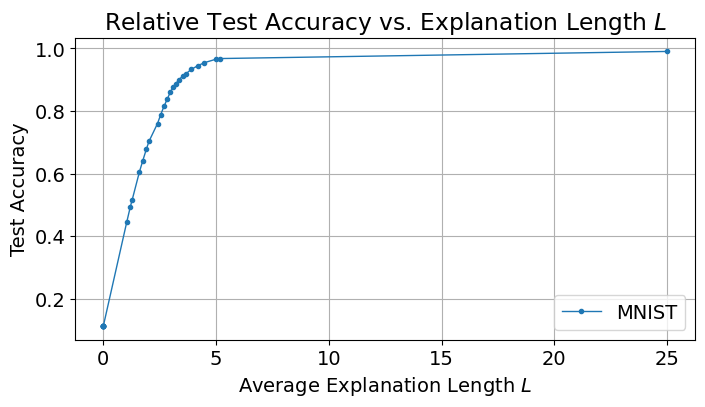

In [190]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title(r"Relative Test Accuracy vs. Explanation Length $L$")
plt.plot(mnist_queries, mnist_acc, '-o', linewidth=1, markersize=3, label='MNIST')
#plt.plot(kmnist_queries, kmnist_acc, '-o', linewidth=1, markersize=3, label='KMNIST')
#plt.plot(fmnist_queries, fmnist_acc, '-o', linewidth=1, markersize=3, label='FashionMNIST')
#plt.plot(cub_queries, cub_acc, '-o', linewidth=1, markersize=3, label='CUB')
#plt.plot(text_queries, text_acc, '-o', linewidth=1, markersize=3, label='HuffPost News')
plt.xlabel(r"Average Explanation Length $L$")
plt.ylabel("Test Accuracy")
plt.grid()
plt.legend()
#plt.savefig("Acc_Minimality_Plot.pdf", bbox_inches='tight')
plt.show()

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
fig.suptitle(r"Test Accuracy vs. Explanation Length $L$", y=0.85)

# ax[0].set_title("Binary Image Classification")
ax[0].plot(mnist_queries, mnist_acc, '-o', linewidth=1, markersize=3, label='MNIST')
ax[0].plot(kmnist_queries, kmnist_acc, '-o', linewidth=1, markersize=3, label='KMNIST')
ax[0].plot(fmnist_queries, fmnist_acc, '-o', linewidth=1, markersize=3, label='FashionMNIST')
ax[0].axvline(5.2, linestyle='--', c='tab:blue', linewidth=1)
ax[0].axvline(12.9, linestyle='--', c='tab:orange', linewidth=1)
ax[0].axvline(14.5, linestyle='--', c='tab:green', linewidth=1)
ax[0].set_xlabel(r"Average Explanation Length")
ax[0].set_ylabel("Test Accuracy")
ax[0].set_ylim(0, 1.02)
ax[0].set_xticks([0, 5, 10, 15, 20, 25])
ax[0].set_xticklabels([0, 5, 10, 15, '...', 676])
ax[0].grid()
                     
# ax[1].set_title("CUB Bird Classification")
ax[1].plot(cub_queries, cub_acc, '-o', linewidth=1, markersize=3, label='CUB', c='tab:red')
ax[1].axvline(14.7, linestyle='--', c='tab:red', linewidth=1)
ax[1].set_xlabel(r"Average Explanation Length")
ax[1].set_ylim(0, 1.02)
ax[1].get_yaxis().set_ticklabels([])
ax[1].set_xticks([0, 5, 10, 15, 20, 25])
ax[1].set_xticklabels([0, 5, 10, 15, '...', 310])
ax[1].grid()

# ax[2].set_title("HuffPost News Document Classification")
ax[2].plot(text_queries, text_acc, '-o', linewidth=1, markersize=3, label='HuffPost News', c='tab:purple')
ax[2].axvline(199.3, linestyle='--', c='tab:purple', linewidth=1)
ax[2].set_xlabel(r"Average Explanation Length")
ax[2].set_ylim(0, 1.02)
ax[2].get_yaxis().set_ticklabels([])
ax[2].set_xticks([0, 50, 100, 150, 200, 250, 300, 350])
ax[2].set_xticklabels([0, 50, 100, 150, 200, 250, '...', 1000])
ax[2].grid()

handles0, labels0 = ax[0].get_legend_handles_labels()
handles1, labels1 = ax[1].get_legend_handles_labels()
handles2, labels2 = ax[2].get_legend_handles_labels()
legend = fig.legend(handles0 + handles1 + handles2, labels0 + labels1 + labels2, loc=(0.125, 0), ncol=5)

plt.tight_layout(pad=2)
plt.savefig("Acc_Minimality_Plot.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

In [13]:
dm = train.CIFAR_VAE.get_datamodule("cifar10")
x, y = next(iter(dm.train_dataloader()))

Files already downloaded and verified
Files already downloaded and verified


In [27]:
checkpoint_path = glob.glob('experiments/lightning_logs/cifar10/lightning_logs/version_37/checkpoints/*.ckpt')[0]

net = train.CIFAR_VAE.get_backbone("cifar10", zdims=128, learn_recon_sigma=False)
model = train.CIFAR_VAE.load_from_checkpoint(checkpoint_path, net=net, epochs=None)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-27-500ed666cd39>:3 in <module>                                             │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: get_backbone() missing 1 required positional argument: 'dataset_name'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


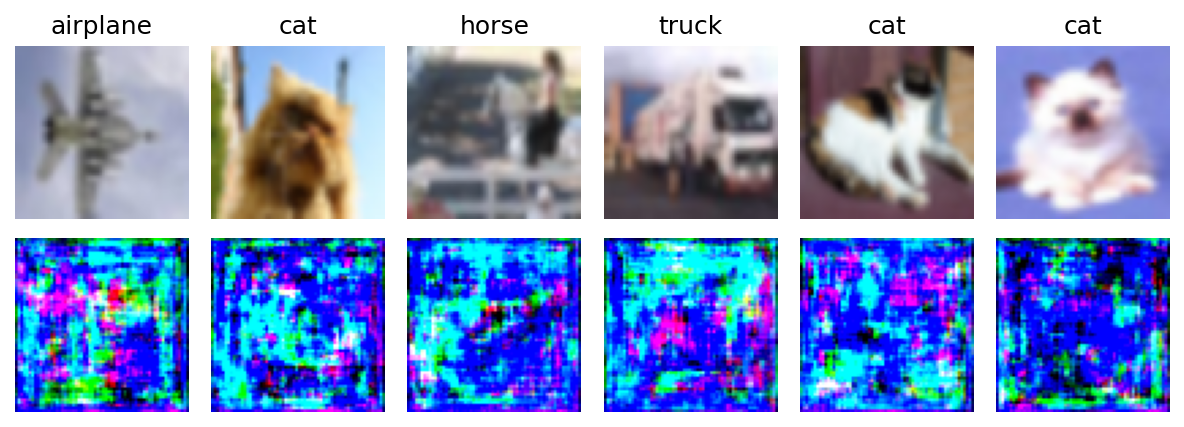

In [28]:
(mu_x, log_sigma_x), _, _ = model.net(x, y)

fig, ax = plt.subplots(2, 6, figsize=(8, 3), dpi=150)
for i in range(ax.shape[1]):
    ax[0, i].set_title(dm.train_dataloader().dataset.classes[y[i]])
    ax[0, i].imshow(x[i].permute(1, 2, 0))
    ax[1, i].imshow(mu_x[i].detach().permute(1, 2, 0))
    ax[0, i].axis('off')
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()

In [26]:
classes = torch.tensor([0, 1, 2, 4, 5, 6])
(mu_x, log_sigma_x), z = model.net.generate(classes)

fig, ax = plt.subplots(1, len(classes), figsize=(8, 1.5), dpi=150)
for i in range(len(ax)):
    ax[i].set_title(dm.train_dataloader().dataset.classes[classes[i]])
    ax[i].imshow(mu_x[i].detach().permute(1, 2, 0))
    ax[i].axis('off')

plt.tight_layout()
plt.show()

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-26-25e8bcdc16ad>:2 in <module>                                             │
│ /cis/home/sslocum/semantic-nlp/cifar_vae.py:305 in generate                               │
│                                                                                           │
│   302 │   │   )                                                                           │
│   303 │                                                                                   │
│   304 │   def generate(self, category):                                                   │
│ ❱ 305 │   │   z_shape = (len(category), self.zdims)                                       │
│   306 │   │   z = utils.vae_sample(                                                       │
│   307 │   │   │   torch.zeros(z_shape, device=category.device),                           │
│   308 │   │   │   torch.ones(z_shape, device=category.device),                            │
│                                                                                           │
│ /cis/home/sslocum/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py:948   │
│ in __getattr__                                                                            │
│                                                                                           │
│    945 │   │   │   if name in modules:                                                    │
│    946 │   │   │   │   return modules[name]                                               │
│    947 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(           │
│ ❱  948 │   │   │   type(self).__name__, name))                                            │
│    949 │                                                                                  │
│    950 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:      │
│    951 │   │   def remove_from(*dicts_or_sets):                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'ResNet_VAE' object has no attribute 'zdims'

In [32]:
#checkpoint_path = glob.glob('experiments/lightning_logs/cifar10/lightning_logs/version_37/checkpoints/*.ckpt')[0]

net = train.CIFAR_VAE.get_backbone("resnet", "cifar10", zdims=128, learn_recon_sigma=False)
model = train.CIFAR_VAE(net=net, epochs=None)
#model = train.CIFAR_VAE.load_from_checkpoint(checkpoint_path, net=net, epochs=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


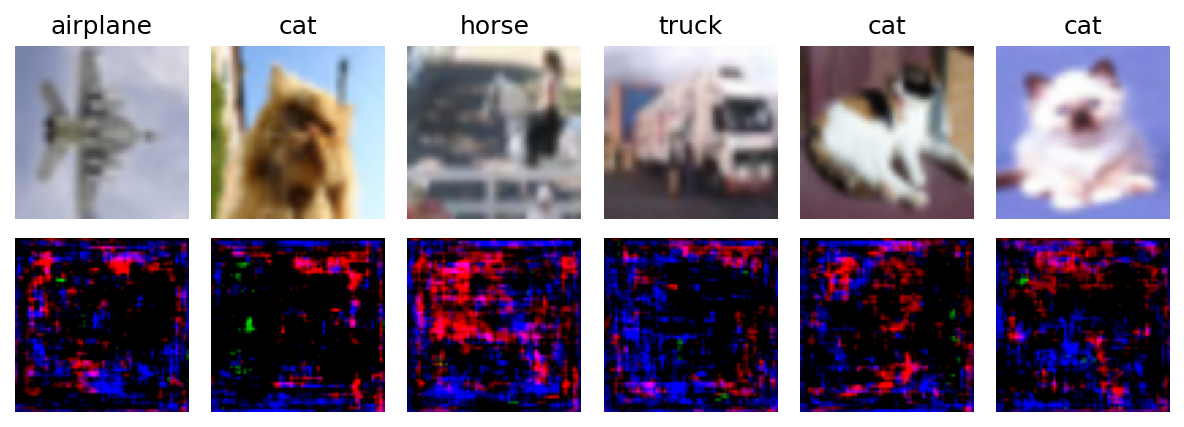

In [33]:
(mu_x, log_sigma_x), _, _ = model.net(x, y)

fig, ax = plt.subplots(2, 6, figsize=(8, 3), dpi=150)
for i in range(ax.shape[1]):
    ax[0, i].set_title(dm.train_dataloader().dataset.classes[y[i]])
    ax[0, i].imshow(x[i].permute(1, 2, 0))
    ax[1, i].imshow(mu_x[i].detach().permute(1, 2, 0))
    ax[0, i].axis('off')
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


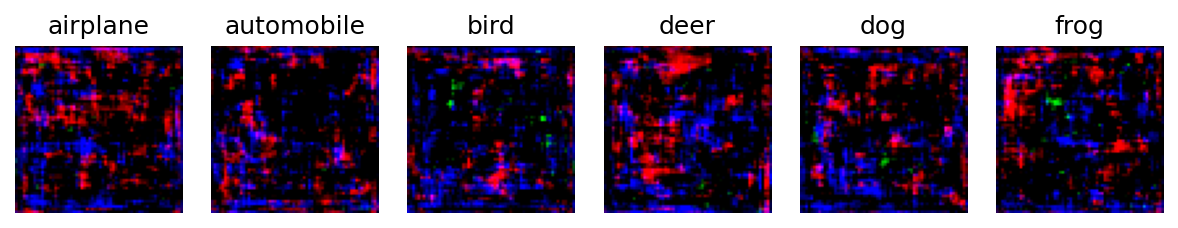

In [34]:
classes = torch.tensor([0, 1, 2, 4, 5, 6])
(mu_x, log_sigma_x), z = model.net.generate(classes)

fig, ax = plt.subplots(1, len(classes), figsize=(8, 1.5), dpi=150)
for i in range(len(ax)):
    ax[i].set_title(dm.train_dataloader().dataset.classes[classes[i]])
    ax[i].imshow(mu_x[i].detach().permute(1, 2, 0))
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [34]:
dm = train.MNIST_MAE.get_datamodule(patch_size=3)
ds = dm.val_dataloader().dataset

In [35]:
(x, mask), y = ds[0]